## ESTA ES UNA VARIACION DEL 000, DONDE AÑADIMOS LA DISTANCIA AL PUNTO FIJO MÁS CERCANO COMO VARIABLE 


Problema inverso para E, que ya funcionaba para la estimación, pero con los desplazamiento regulin.

In [1]:
#librerias

import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import re 
import random
import json 
import time
import plotly.express as px
from dataclasses import dataclass



Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
def keep_line(line):
    line_split=line.split()
    try:
        int(line_split[0])
        #si no dio error, okey entra
        return True
    except:
        return False
    

#vamos a hacer una función para cargar todos los datos de una   
@dataclass
class Data:
    folder: str
    load_stage: int
    base_dir:str = "/home/arturo/Documents/programacion_stuff/DeepElasticity/data/001-LinearElasticity"
    E: str = None
    initialPosition_data_pd: pd.DataFrame =None
    stress_data_pd: pd.DataFrame =None
    displacement_data_pd: pd.DataFrame=None
    restricted_data_pd: pd.DataFrame =None
    force_data_pd: pd.DataFrame =None 
    final_data_pd: pd.DataFrame =None
    collocation_data_np:pd.DataFrame =None
    Pos_min: np.ndarray = None
    Pos_max: np.ndarray = None
    _data_loaded : bool =False

    @classmethod
    def keep_line(line):
        line_split=line.split()
        try:
            int(line_split[0])
            #si no dio error, okey entra
            return True
        except:
            return False

    def load_data(self,load_stage=10,normalize_pos=False):
        # carga las posiciones de los nodos    
        initialPosition_data_path = f"{self.base_dir}/ARTURO_TEST_1/NODES.txt"

        with open(initialPosition_data_path,"r") as f:
            aux_list=f.readlines()

        initialPosition_data=[i for i in aux_list if keep_line(i)]
        initialPosition_data=[i.strip("\n") for i in initialPosition_data]
        initialPosition_data=[i.split() for i in initialPosition_data]
        initialPosition_data_np=np.array(initialPosition_data).astype(float)[:,[0,1,2,3]]
        self.initialPosition_data_pd=pd.DataFrame(initialPosition_data_np,columns=["Node","X","Y","Z"]).set_index("Node")
        self.Pos_min=self.initialPosition_data_pd.min().to_numpy()
        self.Pos_max=self.initialPosition_data_pd.max().to_numpy()

        #noramlizamos las posiciones 
        if normalize_pos:
            self.initialPosition_data_pd=(self.initialPosition_data_pd-self.initialPosition_data_pd.min())/(self.initialPosition_data_pd.max()-self.initialPosition_data_pd.min())


        #carga el streess
        if self.E is not None:
            stress_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_STRESSES_E{self.E}.txt"
        else: 
            stress_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_STRESSES.txt"
        with open(stress_data_path,"r") as f:
            aux_list=f.readlines()


        stress_data=[i for i in aux_list if keep_line(i)]
        stress_data=[i.strip("\n").strip() for i in stress_data]
        patron = "[-.\d]+E-*\d{3}|^\d{0,4}|0\.0000"

        stress_data=[re.findall(patron,i) for i in stress_data]
        stress_data=np.array(stress_data,dtype=float)
        self.stress_data_pd=pd.DataFrame(stress_data,columns=["Node","SX","SY","SZ","SXY","SYZ","SXZ"]).set_index("Node")[["SX","SY","SZ","SYZ","SXZ","SXY"]] # lo queremos asi : s11,s22,s33,s23,s13,s12

        # cargar datos de desplazamiento  
        if self.E is not None:
            displacement_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_DISP_E{self.E}.txt"
        else:
            displacement_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_DISP.txt"

        with open(displacement_data_path,"r") as f:
            aux_list=f.readlines()


        displacement_data=[i for i in aux_list if keep_line(i)]
        displacement_data=[i.strip("\n").strip() for i in displacement_data]
        patron = r"[-.\d]+E-*\d{3}|^\d{0,4}|-?\d+\.\d+|0\.0000"

        displacement_data=[re.findall(patron,i) for i in displacement_data]
        displacement_data=np.array(displacement_data,dtype=float)
        self.displacement_data_pd=pd.DataFrame(displacement_data,columns=["Node","UX","UY","UZ","USUM"]).set_index("Node")

        # cargar datos de boundaries en el movimiento
        #cargar los nodos fijos
        with open(f"{self.base_dir}/ARTURO_TEST_1/RESTRINGED_NODES.txt","r") as f:
            restricted_data=f.readlines()

        restricted_data=[i for i in restricted_data if keep_line(i)]
        restricted_data=[i.strip("\n") for i in restricted_data]
        restricted_data=[i.split() for i in restricted_data]
        restricted_data_np=np.array(restricted_data)[:,[0,1]]
        self.restricted_data_pd=pd.DataFrame(restricted_data_np,columns=["Node","Direccion"])
        self.restricted_data_pd=self.restricted_data_pd.groupby("Node")["Direccion"].apply(lambda x : list(x)).to_frame().sort_index()
        self.restricted_data_pd.index=self.restricted_data_pd.index.astype(int)
        self.restricted_data_pd=self.restricted_data_pd.sort_index()
        self.restricted_data_pd=self.restricted_data_pd.rename(columns={"Direccion":"Restricciones"})

        with open(f"{self.base_dir}/ARTURO_TEST_1/FORCE_ON_NODES.txt","r") as f:
            force_data=f.readlines()


        force_data=[i for i in force_data if keep_line(i)]
        force_data=[i.strip("\n") for i in force_data]
        force_data=[i.split() for i in force_data]
        force_data_np=np.array(force_data)[:,[0,1,2]]
        self.force_data_pd=pd.DataFrame(force_data_np,columns=["Node","Direccion_Fuerza","Fuerza"])
        self.force_data_pd["Fuerza"]=self.force_data_pd["Fuerza"].astype(float)
        self.force_data_pd=self.force_data_pd.set_index("Node")
        self.force_data_pd.index=self.force_data_pd.index.astype(int)


        #ponemos todos los datos en común usando los nodos como clave   
        self.final_data_pd=self.initialPosition_data_pd.merge(self.stress_data_pd,left_index=True,right_index=True,how="left").merge(self.force_data_pd,left_index=True,right_index=True,how="left").merge(self.displacement_data_pd,left_index=True,right_index=True,how="left").merge(self.restricted_data_pd,left_index=True,right_index=True,how="left")

        self.final_data_pd["Final_X"]=self.final_data_pd["X"]-self.final_data_pd["UX"]
        self.final_data_pd["Final_Y"]=self.final_data_pd["Y"]-self.final_data_pd["UY"]
        self.final_data_pd["Final_Z"]=self.final_data_pd["Z"]-self.final_data_pd["UZ"]
        self._data_loaded=True

    def create_colloc_points(self,n_colloc=70000,colloc_type="random_2"):

        if colloc_type=="random_1":

            X_coloc = np.random.uniform(self.Pos_min[0], self.Pos_max[0], (n_colloc, 1))
            Y_coloc = np.random.uniform(self.Pos_min[1], self.Pos_max[1], (n_colloc, 1))
            Z_coloc = np.random.uniform(self.Pos_min[2], self.Pos_max[2], (n_colloc, 1))
            self.collocation_data_np = np.array(np.meshgrid(X_coloc, Y_coloc,Z_coloc)).T.reshape(-1, 3)           # Combine the two arrays
            

        
        elif colloc_type=="random_2":
            #este tipo de random es una distribucion por todo el espacio para cada punto
            points=[]
            for _ in range(n_colloc):
                X_coloc_aux = np.random.uniform(self.Pos_min[0], self.Pos_max[0], 1)
                Y_coloc_aux = np.random.uniform(self.Pos_min[1], self.Pos_max[1], 1)
                Z_coloc_aux = np.random.uniform(self.Pos_min[2], self.Pos_max[2], 1)
                points.append(np.array([X_coloc_aux,Y_coloc_aux,Z_coloc_aux]))

            self.collocation_data_np = np.array(points).reshape(-1, 3)


    def prepare_pytorch_data(self,n_colloc=70000,colloc_type="random_2",percentage_stress_data=0.8,train_percent=0.8):
        #para el entrenamiento necesitamos diferentes conjuntos de datos

        # 1. los datos experimentales que saldrán de los datos sin limitaciones de movimiento
        # pero no haremos ninguna diferenciación más, los que tengan una fuerza aplicada nos da igual
        # lo tomamos también

        # 1.1. Otro set de datos que son los que tienen limitaciones totales del movimiento
        # 1.2. Otro que será los que tengan limitaciones direccionales del movimiento

        # estos dos anteriores, simplemente tienen desplamiento nulo en las direcciones que correspondan
        # por eso lo vamos a meter con los datos normales, pero si quisieramos darles mayor importancia
        # podríamos tenerlos en un término a parte den la funcion de perdida.   

        # 2. Los collocation points, esto son x,y,z repartidas por todo el dominio que nos interese  


        # 3. Las BC. Aquí entran las NBC, y en el futuro la DBC de antes. Antes imponíamos solo donde estaba
        # aplicada la fuerza, pero esto no tiene porque ser así, es más, estamos muy limitados si así es. Si solo quisiéramos 
        # darle información de la Fuerza, habría que ver otra manera creo yo. Por ahora, le voy a dar todos o un subconjunto de los 
        # puntos y valores de sigma en la superficie, para que lo tenga como referencia para aprender la fisica y hacer bien los
        # desplazamientos.

        # Los datos de test será sacados del conjunto de datos no restringidos de desplazamientos

        # El tema de la normalizacion: ----


        # colloc points
        if self.collocation_data_np is None:
            self.create_colloc_points(n_colloc=n_colloc,colloc_type=colloc_type)
        return_colloc_points=torch.tensor(self.collocation_data_np,requires_grad=True)

        # desp_data, tanto los limitados como el resto  

        # no limitados, separamos en 80 y 20
        indx_non_restricted=[int(i) for i in self.displacement_data_pd.index if i not in self.restricted_data_pd.index ]
        random.shuffle(indx_non_restricted)
        self.indx_train_non_restricted,self.indx_test_non_restricted = indx_non_restricted[:int(len(indx_non_restricted)//(1/train_percent))], indx_non_restricted[int(len(indx_non_restricted)//(1/train_percent)):]
        
        train_init_pos_non_restricted, train_disp_non_restricted = torch.tensor(self.initialPosition_data_pd.loc[self.indx_train_non_restricted,["X","Y","Z"]].to_numpy(),requires_grad=True) , torch.tensor(self.displacement_data_pd.loc[self.indx_train_non_restricted,["UX","UY","UZ"]].to_numpy(),requires_grad=True)
        test_init_pos_non_restricted, test_disp_non_restricted = torch.tensor(self.initialPosition_data_pd.loc[self.indx_test_non_restricted,["X","Y","Z"]].to_numpy(),requires_grad=True) , torch.tensor(self.displacement_data_pd.loc[self.indx_test_non_restricted,["UX","UY","UZ"]].to_numpy(),requires_grad=True)

        # limitados
        initpos_restricted_data=torch.tensor(self.initialPosition_data_pd.loc[self.restricted_data_pd.index,["X","Y","Z"]].to_numpy(),requires_grad=True)

        disp_restricted_data=torch.tensor(self.displacement_data_pd.loc[self.restricted_data_pd.index,["UX","UY","UZ"]].to_numpy(),requires_grad=True)

        train_init_pos_main,train_disp_main=torch.concat([train_init_pos_non_restricted,initpos_restricted_data]),torch.concat([train_disp_non_restricted,disp_restricted_data])
        test_init_pos_main,test_disp_main=test_init_pos_non_restricted, test_disp_non_restricted

        #los indices los tenemos trazados:   

        self.index_train=list(self.indx_train_non_restricted) + self.restricted_data_pd.index.to_list() 
        self.index_test=list(self.indx_test_non_restricted)
        # data del NCB
        # voy a escoder un pocentaje de datos de estos de los que dar.
        selected_stresses=self.stress_data_pd.sample(frac=percentage_stress_data,axis=0)
        self.index_stress=selected_stresses.index.to_list()
        position_selected_stresses=torch.tensor(self.initialPosition_data_pd.loc[selected_stresses.index].to_numpy(),requires_grad=True)
        return_stress=torch.tensor(selected_stresses.to_numpy(),requires_grad=True)
        # si quisieramos hacer una separacion
        #from sklearn... import train_test_split
        #train_test_split(self.stress_data_pd.to_numpy())

        return train_init_pos_main.float(),train_disp_main.float(),test_init_pos_main.float(),test_disp_main.float(),position_selected_stresses.float(),return_stress.float(),return_colloc_points.float()


## Calcular la distancia de la data no restringida al punto mas cercano de la data restringida.

In [3]:
data=Data("MULTIPLE_E_VALUES_NEW",10,E="0.005")
data.load_data()

In [48]:
indx_restr=data.restricted_data_pd.index.to_numpy()-1
indx_no_restr=np.array([i-1 for i in data.initialPosition_data_pd.index.to_numpy() if i not in indx_restr],dtype=int)
indx_all=np.array(data.initialPosition_data_pd.index.to_numpy(),dtype=int)-1

In [33]:
post_init_array=data.initialPosition_data_pd.sort_index().to_numpy()

In [53]:
distancias=np.zeros([indx_no_restr.size,indx_restr.size])
for i,indx_no in enumerate(indx_no_restr):
    posicion_no_restringida=post_init_array[indx_no]
    for j,indx_si in enumerate(indx_restr):
        distancias[i,j]=np.linalg.norm(posicion_no_restringida- post_init_array[indx_si])


In [56]:
np.sum(distancias==0)

252

In [57]:
distancias=np.zeros([indx_all.size,indx_restr.size])
for i,indx in enumerate(indx_all):
    posicion=post_init_array[indx]
    for j,indx_si in enumerate(indx_restr):
        distancias[i,j]=np.linalg.norm(posicion - post_init_array[indx_si])


In [58]:
dist_minimas=distancias.min(axis=1)

In [91]:
train_init_pos_main,train_disp_main,test_init_pos_main,test_disp_main,position_selected_stresses,return_stress,return_colloc_points=data.prepare_pytorch_data()

In [92]:
train_init_pos_main=torch.cat((train_init_pos_main,torch.tensor(dist_minimas[np.array(data.index_train)-1]).unsqueeze(1)),axis=1)
test_init_pos_main=torch.cat((test_init_pos_main,torch.tensor(dist_minimas[np.array(data.index_test)-1]).unsqueeze(1)),axis=1)

In [5]:
print(train_init_pos_main.shape,train_disp_main.shape,test_init_pos_main.shape,test_disp_main.shape,position_selected_stresses.shape,return_stress.shape,return_colloc_points.shape)

torch.Size([3452, 3]) torch.Size([3452, 3]) torch.Size([699, 3]) torch.Size([699, 3]) torch.Size([1339, 3]) torch.Size([1339, 6]) torch.Size([70000, 3])


In [6]:
#px.scatter_3d(data_frame=pd.DataFrame(data.collocation_data_np,columns=["X","Y","Z"]),x="X",y="Y",z="Z")

Y aqui me doy cuenta que si lo hago paara esa data, lo tengo que hacer para toda la data incluido los puntos de colocación, y no estoy preparado para  seguir con eso.

# Redefinición de la PINN  

La pinn implementa el calculo de los gradientes.    

**Esta pinn solo da como resultado los desplazamientos, no las tensiones**

In [93]:
def normalize(X_tensor, X_min, X_max):
    """
    Normalize a tensor by columns given a max and min of each column.
    
    Parameters:
    X_tensor(numpy array): Tensor to be normalized.
    """
    # Normalize input vector X by each feature
    (num_row_X, num_col_X) = X_tensor.shape
    normalized_X_tensor = torch.zeros_like(X_tensor)
    
    # Fill the copy vector
    for col in range(num_col_X):
        min_X_col = X_min[col]
        max_X_col = X_max[col]
        normalized_X_tensor[:,col] = (X_tensor[:,col]-min_X_col)/(max_X_col-min_X_col)#(X_tensor[:,col]-min_X_col)*2/(max_X_col-min_X_col)# -1 #para que es este -1?  
        
    return normalized_X_tensor

def unnormalize(X_tensor, X_min, X_max):
    """
    Unnormalize a tensor by columns given a max and min of each column.
    
    Parameters:
    X_tensor(numpy array): Tensor to be unnormalized.
    X_max(numpy array): Max of each column of the tensor to be unnormalized.
    X_min(numpy array): Min of each column of the tensor to be unnormalized.
    """
    # Unnormalize input vector X by each feature
    (num_row_X, num_col_X) = X_tensor.shape
    unnormalized_X_tensor = torch.zeros_like(X_tensor)
    
    # Fill the copy vector
    for col in range(num_col_X):
        unnormalized_X_tensor[:,col] = (X_tensor[:,col])*(X_max[col]-X_min[col]) + X_min[col]#(X_tensor[:,col]+1)*(X_max[col]-X_min[col])/2 + X_min[col]
        
    return unnormalized_X_tensor

In [94]:
# Red neuronal  

class DNN(nn.Module):
    def __init__(self,layers,init_w="xavier"):
        super().__init__() 
        self.layers=layers
        self.activation = nn.Tanh()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
        if init_w=="xavier":
            #Xavier Normal Initialization
            for i in range(len(layers)-1):
                nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
                
                # set biases to zero
                nn.init.zeros_(self.linears[i].bias.data)
        # elif init_w=="gorot":
        #         nn.init. (self.linears[i].weight.data, gain=1.0)
                
        #         # set biases to zero
        #         nn.init.zeros_(self.linears[i].bias.data)


    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)             

        #xn = normalize(x, Pos_min, Pos_max)

        # convert to float
        a = x.float()
        

        # inpunt and hidden layers forward computation
        for i in range(len(self.layers)-2):
            z = self.linears[i](a)          
            a = self.activation(z)

        # output layer forward computation            
        b = self.linears[-1](a)
        
        return b

In [95]:
class PINN(DNN):
    '''
        Esta clase hace el registro de todos los parámetros, los cálculos de derivadas y de losses
        Y aplica las restricciones que hagan falta
    '''
    def __init__(self, layers,init_values=None,device=None,separate_data_losses=True,loss_weights={"Data":1,"PDE":1,"BC":1}):
        super().__init__(layers)
        
        if device is None:
            self.device= "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device=device
        self.to(self.device)


        #History of losses
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "BC": [],
                             "Total":[]}
         #Parameters trials
        self.params_history = { "E": [] ,
                                "alpha": []}

        #inicialización de parametros
        self.nu = init_values[0]
        self.alpha = nn.Parameter(torch.tensor(init_values[2],dtype=torch.float32).to(self.device))
        self.E_ref = init_values[1]
        self.E = torch.tensor((1+self.alpha)*self.E_ref,dtype=torch.float32).to(self.device)
        self.separate_data_losses=separate_data_losses
        self.loss_function = nn.MSELoss(reduction ='mean')

        self.w_data=loss_weights["Data"]
        self.w_PDE=loss_weights["PDE"]
        self.w_BC=loss_weights["BC"]
        self.iter_n=0

    def compute_XYZ(self, positions):
        # clone the input data and add AD
        pos = positions.clone().to(self.device)
        X = pos[:,0].reshape(-1,1)
        Y = pos[:,1].reshape(-1,1)
        Z = pos[:,2].reshape(-1,1)
        return X, Y, Z

    def compute_displacements(self,X, Y, Z):
        XYZ = torch.cat((X,Y,Z), dim=1).to( self.device )
        # Compute the output of the DNN
        U = self(XYZ)
        # Separating vector of directional displacements
        u = U[:,0].reshape(-1,1)
        v = U[:,1].reshape(-1,1)
        w = U[:,2].reshape(-1,1)
        return u, v, w

    # Los cálculos de las funciones de pérdida de hacen 1 vez, y luego ya vemos que hacemos
    # con esos datos, si usar pesos, si usar otras cosas...

    def loss_PDE(self, collocation_points, save = True):
        # estos son los puntos en los que imponemos las leyes físicas  
        # puede ser la ecuación de equilibrio, pero también pueden ser otras relaciones
        # que conozcamos entre inputs y outputs, como por ejemplo, relaciones termodinámicas etc..
        # si el output fuera posicion y tensión, entonces podriamos imponer la ley de hooke sobre este
        # input.
        X, Y, Z = self.compute_XYZ(collocation_points)
        u, v, w = self.compute_displacements(X,Y,Z)


        # y ahora tenemos que obtener las derivadas necesarias para aplicar la eq de equilibrio
        epsilon = self.compute_strain(X,Y,Z,u, v, w)
        sigma = self.compute_stress(epsilon)
        div_sigma = self.divergence(sigma,X, Y, Z)

        value_loss_PDE=self.loss_function(div_sigma,torch.zeros_like(div_sigma).to(self.device))
        
        if save:
            self.loss_history["PDE"].append(value_loss_PDE.item())#.to('cpu').detach().numpy())
        
        return value_loss_PDE
    
    def loss_BC(self,pos_reales,sigmas_reales,save=True):
        #aqui tenemos las de Dirichlet y las de Neumann
        # en mi caso que no hay contacto ni nada, pero si tengo nodos fijos!! las de Dirichlet tbn

        #en esta implementación voy a imponer las sigmas solo aqui, en una futura, podría meter también
        #las de Dirichlet para poder darles mas peso

        #calculamos sobre las posiciones de las sigmas que tenemos, las dadas por el modelo
        # predict U
        X,Y,Z=self.compute_XYZ(pos_reales)
        u, v, w=self.compute_displacements(X,Y,Z)
        
        epsilon = self.compute_strain(X,Y,Z,u, v, w)
        sigma = self.compute_stress(epsilon) 
        #este sigma tiene primera dimension batchsize, y segunda dimension 6
        #que corresponde con: s11,s22,s33,s23,s13,s12
        #le imponemos que sean iguales de modo que aplicamos la loss y ya
        value_loss_BC=self.loss_function(sigma,sigmas_reales)

        if save:
            self.loss_history["BC"].append(value_loss_BC.item())#.to('cpu').detach().numpy())

        return value_loss_BC

    #def loss_DBC(fix_nodes)
    #   pass

    def loss_data(self, pos_reales,desp_reales,save=True):
        #pos_reales=pos_reales.to(device)
        u_predict=self(pos_reales)
        if self.separate_data_losses:
            sepatared_loss=torch.nn.MSELoss(reduction="none")
            #aux=self.loss_function(u_predict,desp_reales)
            #esto nos devuelve la diferencia cuadrática de cada elemento, para evaluarlos por
            #separado, vamos a hacer la media en columnas
            # x_mse,y_mse,z_mse=torch.mean(aux,axis=0)
            # x_mse,y_mse,z_mse=torch.sqrt(x_mse),torch.sqrt(y_mse),torch.sqrt(z_mse)
            value_loss_data=torch.mean(torch.sqrt(torch.mean(sepatared_loss(u_predict,desp_reales),axis=0)))
        else:
            value_loss_data=self.loss_function(u_predict,desp_reales)

        if save:
            self.loss_history["Data"].append(value_loss_data.item())#.to('cpu').detach().numpy())
        
        return value_loss_data
    
    def loss(self, pos_data,desp_data,pos_colloc,pos_BC,sigmas_BC,save=True):
        #esto hace que se calculen todas las losses de la pinn
        #además, si tenemos un parámetro E, este se actualizará, pe si estamos actualizando alpha en lugar
        #de E, despues de la recalculación tendremos que actualizar E. 

        #actualizamos E antes de calcular nada

        self.E=(1+self.alpha)*self.E_ref

        value_loss_PDE=self.loss_PDE(pos_colloc,save=save)
        value_loss_BC=self.loss_BC(pos_BC,sigmas_BC,save=save)
        value_loss_data=self.loss_data(pos_data,desp_data,save=save)  
        value_loss= self.w_data*value_loss_data + self.w_PDE*value_loss_PDE+ self.w_BC*value_loss_BC


        if save: 
            #self.params_history["nu"].append(self.nu)#self.nu.to('cpu').detach().numpy())
            self.params_history["E"].append(self.E.to('cpu').detach().numpy())
            self.params_history["alpha"].append(self.alpha.to('cpu').detach().numpy())
            self.loss_history["Total"].append(value_loss.item())#.to('cpu').detach().numpy())

        return value_loss

    def compute_gradU(self, X, Y, Z, U, V, W):

        # Compute the gradient of U
        Ux,Uy,Uz = autograd.grad(U, (X,Y,Z), torch.ones([X.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)
        # Uy = autograd.grad(U, Y, torch.ones([Y.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]
        # Uz = autograd.grad(U, Z, torch.ones([Z.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]

        # Compute the gradient of V
        Vx,Vy,Vz = autograd.grad(V, (X,Y,Z), torch.ones([X.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)
        # Vy = autograd.grad(V, Y, torch.ones([Y.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]
        # Vz = autograd.grad(V, Z, torch.ones([Z.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]

        # Compute the gradient of W
        Wx,Wy,Wz = autograd.grad(W, (X,Y,Z), torch.ones([X.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)
        # Wy = autograd.grad(W, Y, torch.ones([Y.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]
        # Wz = autograd.grad(W, Z, torch.ones([Z.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]

        grad_u = torch.cat((Ux , Uy, Uz), dim=1).to(torch.float32)
        grad_v = torch.cat((Vx , Vy, Vz), dim=1).to(torch.float32)
        grad_w = torch.cat((Wx , Wy, Wz), dim=1).to(torch.float32)

        gradU = torch.cat((grad_u, grad_v, grad_w), dim=1).to(torch.float32).reshape(-1,3,3)

        return gradU

    def compute_strain(self, X,Y,Z,u, v, w):
        # Compute strain components using autograd
        nabla_U = self.compute_gradU(X,Y,Z,u, v, w).squeeze()
        strain = 0.5 * (nabla_U + nabla_U.swapaxes(1,2))
        return strain


    def compute_stress(self,strain):
        strain_flat=strain[:,(0,1,2,1,0,0),(0,1,2,2,2,1)]*torch.tensor([1,1,1,2,2,2],dtype=torch.float32).to(self.device)
        #strain_flat=strain[:,(0,1,2,0,0,1),(0,1,2,1,2,2)] # e00,e11,e22,e01,e02,e12
        self.C=(self.E/((1+self.nu)*(1-2*self.nu)))*torch.tensor(
                [[1-self.nu,self.nu,self.nu,0,0,0],
                [self.nu,1-self.nu,self.nu,0,0,0],
                [self.nu,self.nu,1-self.nu,0,0,0],
                [0,0,0,(1-2*self.nu)/2,0,0],
                [0,0,0,0,(1-2*self.nu)/2,0],
                [0,0,0,0,0,(1-2*self.nu)/2]]).float().to(self.device)

        return torch.matmul(self.C,strain_flat.T.float()).T.squeeze() #s11,s22,s33,s23,s13,s12

    def divergence(self,sigma, X, Y, Z):
        div_T = torch.zeros(sigma.shape[0],3)
        div_T[:,0]=autograd.grad(sigma[:,0],X,grad_outputs=torch.ones_like(sigma[:,0]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,5],Y,grad_outputs=torch.ones_like(sigma[:,5]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,4],Z,grad_outputs=torch.ones_like(sigma[:,4]).to(self.device),retain_graph=True)[0].squeeze()
        div_T[:,1]=autograd.grad(sigma[:,5],X,grad_outputs=torch.ones_like(sigma[:,5]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,1],Y,grad_outputs=torch.ones_like(sigma[:,1]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,3],Z,grad_outputs=torch.ones_like(sigma[:,3]).to(self.device),retain_graph=True)[0].squeeze()
        div_T[:,2]=autograd.grad(sigma[:,4],X,grad_outputs=torch.ones_like(sigma[:,4]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,3],Y,grad_outputs=torch.ones_like(sigma[:,3]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,2],Z,grad_outputs=torch.ones_like(sigma[:,2]).to(self.device),retain_graph=True)[0].squeeze()

        return div_T
    

    def step_closure(self,opt,train_init_pos_main2,train_disp_main2,return_colloc_points2,position_selected_stresses2,return_stress2):
        
        opt.zero_grad()
        
        loss = self.loss(train_init_pos_main2,train_disp_main2,return_colloc_points2,position_selected_stresses2,return_stress2)
        
        loss.backward()
        self.iter_n+=1
        # Print material parameters and loss evolition
        print(f'LBFGS iter: {self.iter_n}, Loss: {loss.item()}')
            
        
        return loss


# Entrenamiento

In [97]:
#tenemos que cargar correctamente los datos para usarlos
data=Data("MULTIPLE_E_VALUES_NEW",10,E="0.005")
data.load_data()
train_init_pos_main,train_disp_main,test_init_pos_main,test_disp_main,position_selected_stresses,return_stress,return_colloc_points=data.prepare_pytorch_data()
train_init_pos_main=torch.cat((train_init_pos_main,torch.tensor(dist_minimas[np.array(data.index_train)-1]).unsqueeze(1)),axis=1)
test_init_pos_main=torch.cat((test_init_pos_main,torch.tensor(dist_minimas[np.array(data.index_test)-1]).unsqueeze(1)),axis=1)

<Axes: >

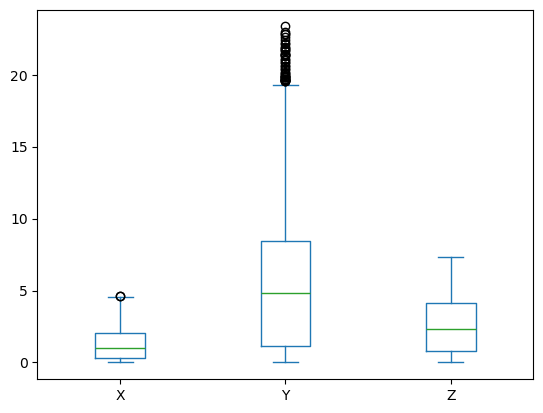

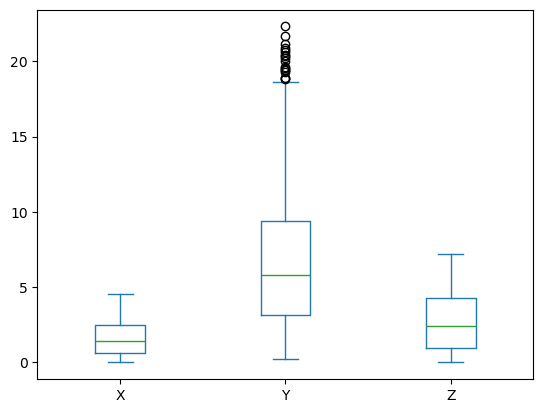

In [77]:
pd.DataFrame(np.abs(train_disp_main.cpu().detach().numpy()),columns=["X","Y","Z"]).plot(kind="box")
pd.DataFrame(np.abs(test_disp_main.cpu().detach().numpy()),columns=["X","Y","Z"]).plot(kind="box")

In [78]:
data.initialPosition_data_pd.filter(data.index_stress,axis=0)

,X,Y,Z
137.0,44.333,29.967,20.782
230.0,26.238,56.629,43.909
563.0,18.650,33.314,42.476
396.0,32.563,24.096,52.792
1070.0,54.335,55.722,49.693
...,...,...,...
525.0,33.991,33.636,18.379
1094.0,56.499,44.233,27.798
1304.0,31.674,55.551,52.256
1381.0,62.836,35.597,43.622


In [79]:
px.scatter_3d(data.initialPosition_data_pd.filter(data.stress_data_pd.index,axis=0),x="X",y="Y",z="Z",color=data.stress_data_pd.sum(axis=1).to_numpy())

In [35]:
pinn=PINN([4,80,80,80,80,80,80,3],[.4,1,0.05])

/tmp/ipykernel_10090/117987449.py:29: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [36]:
print(type(train_init_pos_main),type(train_disp_main),type(return_colloc_points),type(position_selected_stresses),type(return_stress))

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


In [164]:
loss=pinn.loss(train_init_pos_main.to(float),train_disp_main,return_colloc_points,position_selected_stresses,return_stress)


In [52]:
loss.backward()

In [98]:
pinn=PINN([4,50,50,50,50,3],[0.4,0.05,1],loss_weights={"Data":4,"PDE":1e6,"BC":1e4})

opt=torch.optim.Adam(pinn.parameters(),lr=1e-3)
for epoch in range(1000):
    loss=pinn.loss(train_init_pos_main,train_disp_main,return_colloc_points,position_selected_stresses,return_stress)
    print("Epoch: ", epoch, "loss: ", loss.item())
    loss.backward()
    opt.step()
    opt.zero_grad()

/tmp/ipykernel_23979/117987449.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.E = torch.tensor((1+self.alpha)*self.E_ref,dtype=torch.float32).to(self.device)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (70000x3 and 4x50)

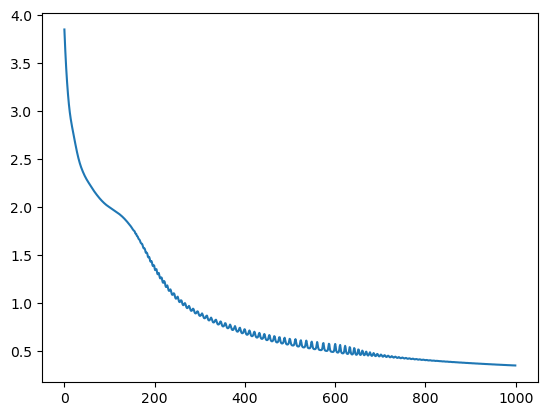

In [105]:
plt.plot(pinn.loss_history["Data"])

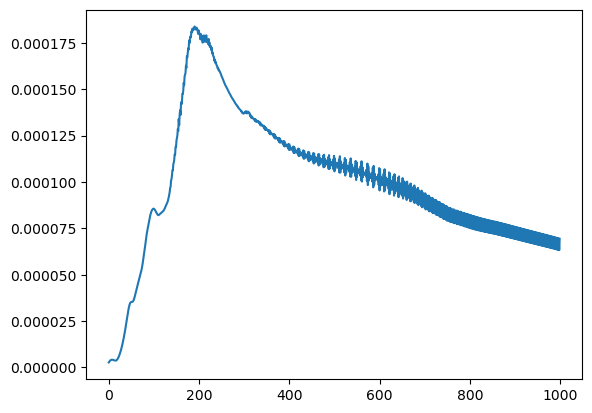

In [106]:
plt.plot(pinn.loss_history["PDE"])

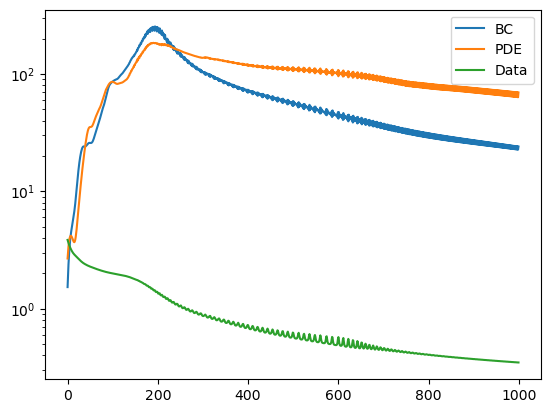

In [107]:
plt.plot(np.array(pinn.loss_history["BC"])*1e5,label="BC")
plt.plot(np.array(pinn.loss_history["PDE"])*1e6,label="PDE")
plt.plot(np.array(pinn.loss_history["Data"]),label="Data")
plt.yscale("log")
plt.legend()

In [108]:
loss=torch.nn.MSELoss( reduction="none")

In [109]:
errors2=loss(pinn(test_init_pos_main),test_disp_main)

In [110]:
rel_errors=torch.abs(pinn(test_init_pos_main)-test_disp_main)/test_disp_main

In [111]:
rel_errors_pd=pd.DataFrame(rel_errors.detach().cpu().numpy(),columns=["rel_err_X","rel_err_Y","rel_err_Z"])
rel_errors_pd

,rel_err_X,rel_err_Y,rel_err_Z
0,0.106205,-0.005266,0.274156
1,0.004577,-0.397095,0.076962
2,0.006016,-0.000539,0.033129
3,0.015302,-0.053091,0.008322
4,0.180310,-0.004186,0.021624
...,...,...,...
694,-4.606865,-0.091882,-0.056113
695,-0.429774,-0.011682,0.002369
696,-0.174114,-0.056919,-0.143649
697,-0.027757,-0.024304,0.029538


(-1.0, 1.0)

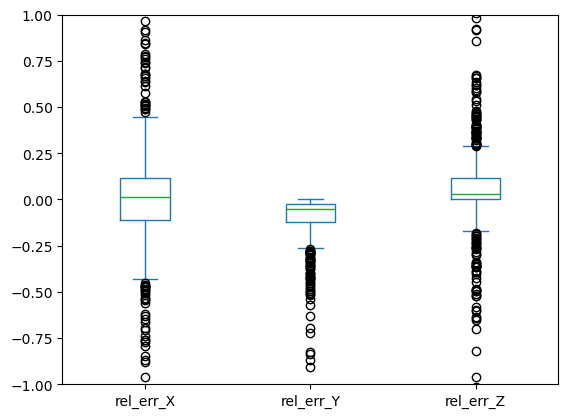

In [112]:
rel_errors_pd.plot(kind="box")
plt.ylim([-1,1])

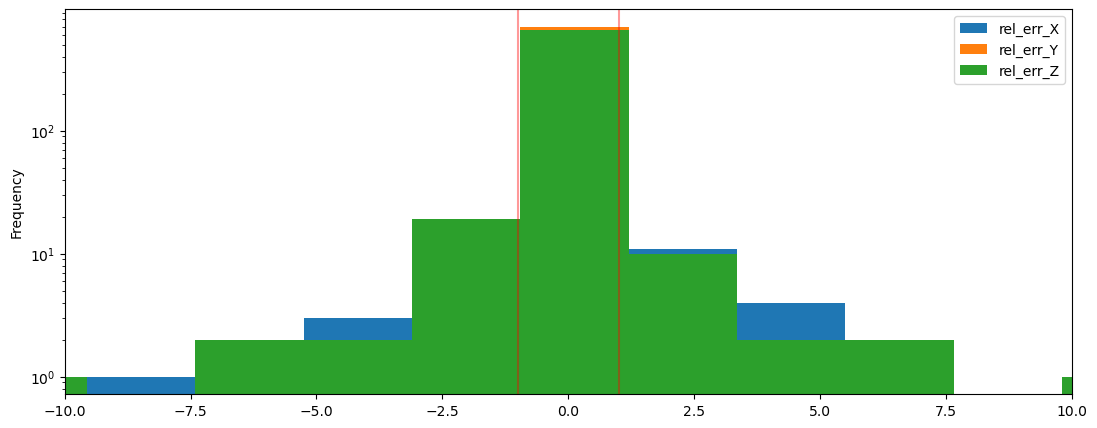

In [113]:
plt.figure(figsize=(13,5))
ax=plt.gca()
rel_errors_pd.plot(kind="hist",bins=300,ax=ax)
plt.yscale("log")
plt.xlim([-10,10])
plt.axvline(x=1,color="red",alpha=0.4)
plt.axvline(x=-1,color="red",alpha=0.4)

In [114]:
aux_plot=pd.concat([pd.DataFrame(test_init_pos_main.detach().cpu().numpy(),columns=["X","Y","Z"]),pd.DataFrame(test_disp_main.detach().cpu().numpy(),columns=["U","V","W"])],axis=1)
aux_plot["USUM"]=np.sqrt(aux_plot["U"]**2+aux_plot["V"]**2+aux_plot["W"]**2)
aux_plot

,X,Y,Z,U,V,W,USUM
0,60.327000,42.020000,52.556000,4.535200,-5.31730,1.6144,7.172727
1,50.952999,28.558001,34.118000,0.648700,-0.43623,0.8313,1.141126
2,60.254002,42.300999,48.701000,3.523800,-4.43610,1.3981,5.835310
3,48.637001,42.192001,49.505001,2.474500,-7.05000,5.1518,9.075610
4,43.666000,44.632000,54.390999,1.376900,-8.06440,6.7580,10.611360
...,...,...,...,...,...,...,...
694,38.444000,36.209999,28.179001,-0.069818,-5.66410,-0.9563,5.744686
695,37.376999,55.514999,51.553001,-0.284250,-12.84500,6.1962,14.264212
696,30.056999,42.570000,17.773001,-2.470900,-10.98500,-3.0987,11.678078
697,33.946999,46.785999,54.640999,-1.429900,-8.96590,6.9552,11.437079


In [115]:
px.scatter_3d(aux_plot,x="X",y="Y",z="Z",color="USUM")

In [122]:
aux_pred=pd.DataFrame(pinn(test_init_pos_main).detach().cpu().numpy(),columns=["pred_U","pred_V","pred_W"])
aux_plot["pred_X"]=aux_plot["X"]+aux_pred["pred_U"]
aux_plot["pred_Y"]=aux_plot["Y"]+aux_pred["pred_V"]
aux_plot["pred_Z"]=aux_plot["Z"]+aux_pred["pred_W"]
aux_plot["real_X"]=aux_plot["X"]+aux_plot["U"]
aux_plot["real_Y"]=aux_plot["Y"]+aux_plot["V"]
aux_plot["real_Z"]=aux_plot["Z"]+aux_plot["W"]
aux_plot["dif_real_pred_X"]=aux_plot["real_X"]-aux_plot["pred_X"]
aux_plot["dif_real_pred_Y"]=aux_plot["real_Y"]-aux_plot["pred_Y"]
aux_plot["dif_real_pred_Z"]=aux_plot["real_Z"]-aux_plot["pred_Z"]
aux_plot["relativ_dif_real_pred_X"]=aux_plot["dif_real_pred_X"]/aux_plot["U"]
aux_plot["relativ_dif_real_pred_Y"]=aux_plot["dif_real_pred_Y"]/aux_plot["V"]
aux_plot["relativ_dif_real_pred_Z"]=aux_plot["dif_real_pred_Z"]/aux_plot["W"]

In [123]:
aux_plot

,X,Y,Z,U,V,W,USUM,pred_X,pred_Y,pred_Z,real_X,real_Y,real_Z,dif_real_pred_X,dif_real_pred_Y,dif_real_pred_Z,relativ_dif_real_pred_X,relativ_dif_real_pred_Y,relativ_dif_real_pred_Z
0,60.327000,42.020000,52.556000,4.535200,-5.31730,1.6144,7.172727,64.380539,36.730701,54.612995,64.862198,36.702702,54.170399,0.481659,-0.028000,-0.442596,0.106205,0.005266,-0.274155
1,50.952999,28.558001,34.118000,0.648700,-0.43623,0.8313,1.141126,51.598732,28.294994,34.885323,51.601700,28.121771,34.949299,0.002968,-0.173223,0.063976,0.004575,0.397092,0.076959
2,60.254002,42.300999,48.701000,3.523800,-4.43610,1.3981,5.835310,63.756603,37.867290,50.052784,63.777802,37.864899,50.099102,0.021198,-0.002392,0.046318,0.006016,0.000539,0.033129
3,48.637001,42.192001,49.505001,2.474500,-7.05000,5.1518,9.075610,51.149368,35.516289,54.613930,51.111500,35.142002,54.656799,-0.037868,-0.374287,0.042870,-0.015303,0.053090,0.008321
4,43.666000,44.632000,54.390999,1.376900,-8.06440,6.7580,10.611360,44.794632,36.533844,61.295135,45.042900,36.567600,61.148998,0.248268,0.033756,-0.146137,0.180309,-0.004186,-0.021624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,38.444000,36.209999,28.179001,-0.069818,-5.66410,-0.9563,5.744686,38.052540,30.025471,27.276361,38.374184,30.545898,27.222700,0.321644,0.520428,-0.053661,-4.606890,-0.091882,0.056114
695,37.376999,55.514999,51.553001,-0.284250,-12.84500,6.1962,14.264212,37.214912,42.820061,57.763882,37.092751,42.669998,57.749203,-0.122162,-0.150063,-0.014679,0.429769,0.011683,-0.002369
696,30.056999,42.570000,17.773001,-2.470900,-10.98500,-3.0987,11.678078,28.016317,32.210251,14.229175,27.586100,31.584999,14.674301,-0.430218,-0.625252,0.445127,0.174114,0.056919,-0.143649
697,33.946999,46.785999,54.640999,-1.429900,-8.96590,6.9552,11.437079,32.477409,38.038002,61.390755,32.517097,37.820099,61.596199,0.039688,-0.217903,0.205444,-0.027756,0.024304,0.029538


In [126]:
#aux_plot.to_pickle("pickle_aux_plot_df.pkl")
aux_plot=pd.read_pickle("pickle_aux_plot_df.pkl")

In [118]:
px.scatter_3d(aux_plot,x="real_X",y="real_Y",z="real_Z",color="USUM")

In [119]:
px.scatter_3d(aux_plot,x="pred_X",y="pred_Y",z="pred_Z",color="USUM")

In [125]:
px.scatter_3d(aux_plot.loc[aux_plot["relativ_dif_real_pred_Y"]>0.2],x="pred_X",y="pred_Y",z="pred_Z",color="USUM")

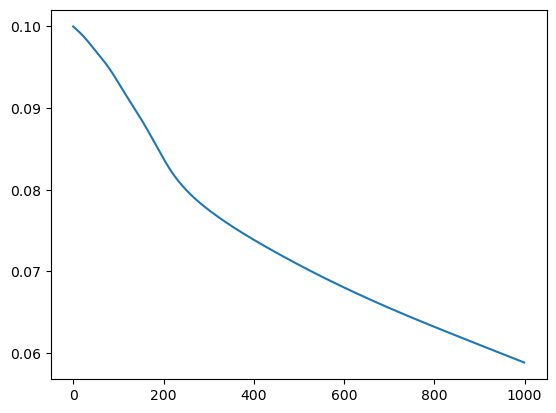

In [128]:
plt.plot([i.item() for i in pinn.params_history["E"]])

(array([298.,  76.,  57.,  36.,  30.,  18.,  17.,  26.,  14.,   8.,   8.,
          8.,   6.,   4.,   9.,   2.,   5.,   3.,   4.,   5.,   4.,   1.,
          7.,   4.,   4.,   1.,   2.,   7.,   2.,   0.,   3.,   0.,   2.,
          1.,   0.,   4.,   2.,   0.,   1.,   1.,   1.,   0.,   1.,   2.,
          1.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          1.]),
 array([3.42079032e-09, 3.93751368e-04, 7.87499303e-04, 1.18124729e-03,
        1.57499523e-03, 1.96874328e-03, 2.36249110e-03, 2.75623915e-03,
        3.14998697e-03, 3.54373502e-03, 3.93748283e-03, 4.33123065e-03,
        4.72497893e-03, 5.11872675e-03, 5.51247457e-03, 5.90622285e-03,
        6.29997067e-03, 6.6937

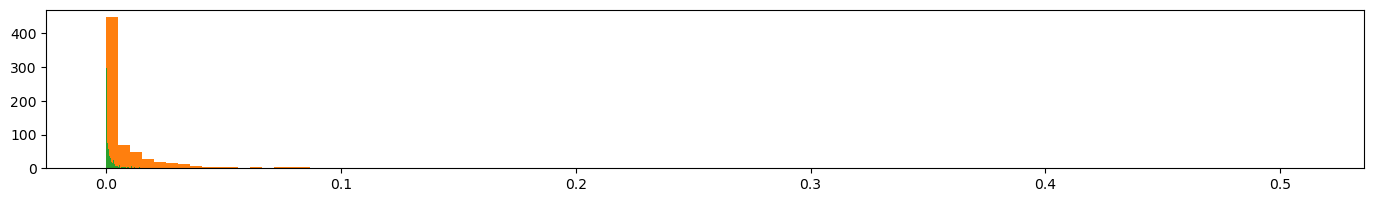

In [90]:
plt.figure(figsize=(17,7))
plt.subplot(3,1,1)
plt.hist(err_x,bins=100)
plt.subplot(3,1,1)
plt.hist(err_y,bins=100)
plt.subplot(3,1,1)
plt.hist(err_z,bins=100)

In [167]:
#tenemos que cargar correctamente los datos para usarlos
data2=Data("LINEAR_SMALL_DISP",10)
data2.load_data()
train_init_pos_main2,train_disp_main2,test_init_pos_main2,test_disp_main2,position_selected_stresses2,return_stress2,return_colloc_points2=data2.prepare_pytorch_data()

In [174]:
from functools import partial

In [178]:
pinn2=PINN([3,80,80,80,80,80,3],[0.4,0.05,1],loss_weights={"Data":1,"PDE":1e6,"BC":1e5})

opt1=torch.optim.Adam(pinn2.parameters(),lr=1e-3)
#opt2 = optim.LBFGS(pinn2.parameters(), lr=1e-3)

for epoch in range(420):

    opt1.zero_grad()
    loss=pinn2.loss(train_init_pos_main2,train_disp_main2,return_colloc_points2,position_selected_stresses2,return_stress2)
    loss.backward()
    opt1.step()
    # else:
    #     # Para L-BFGS-B, necesitas definir una clausura para la optimización
    #     def closure():
    #         opt2.zero_grad()
    #         loss=pinn2.loss(train_init_pos_main2,train_disp_main2,return_colloc_points2,position_selected_stresses2,return_stress2)
    #         loss.backward()
    #         return loss
    #     opt2.step(closure)
    print("Epoch: ", epoch, "loss: ", loss.item())

    

params = list(pinn2.parameters())



# 'Measure execution time'
start_time = time.time()

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(params, 1e-3, 
                            max_iter = 5000, 
                            max_eval = None, 
                            tolerance_grad = 1e-11, 
                            tolerance_change = 1e-11, 
                            line_search_fn = 'strong_wolfe',
                            history_size = 100)


optimizer.step(partial(pinn2.step_closure,optimizer,train_init_pos_main2,train_disp_main2,return_colloc_points2,position_selected_stresses2,return_stress2))




/tmp/ipykernel_77247/117987449.py:29: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch:  0 loss:  5.049416542053223
Epoch:  1 loss:  2.4294509887695312
Epoch:  2 loss:  1.574845790863037
Epoch:  3 loss:  1.3017407655715942
Epoch:  4 loss:  1.2654796838760376
Epoch:  5 loss:  1.2052721977233887
Epoch:  6 loss:  1.1538429260253906
Epoch:  7 loss:  1.1115103960037231
Epoch:  8 loss:  1.0627353191375732
Epoch:  9 loss:  1.0035840272903442
Epoch:  10 loss:  0.934256374835968
Epoch:  11 loss:  0.8671561479568481
Epoch:  12 loss:  0.8166801333427429
Epoch:  13 loss:  0.7903278470039368
Epoch:  14 loss:  0.7797830104827881
Epoch:  15 loss:  0.772040069103241
Epoch:  16 loss:  0.7651084661483765
Epoch:  17 loss:  0.7590916752815247
Epoch:  18 loss:  0.7511444091796875
Epoch:  19 loss:  0.7388071417808533
Epoch:  20 loss:  0.7233721613883972
Epoch:  21 loss:  0.7077020406723022
Epoch:  22 loss:  0.6932650804519653
Epoch:  23 loss:  0.6808807849884033
Epoch:  24 loss:  0.6710971593856812
Epoch:  25 loss:  0.6638190746307373
Epoch:  26 loss:  0.6586575508117676
Epoch:  27 loss

tensor(1.4308, grad_fn=<AddBackward0>)

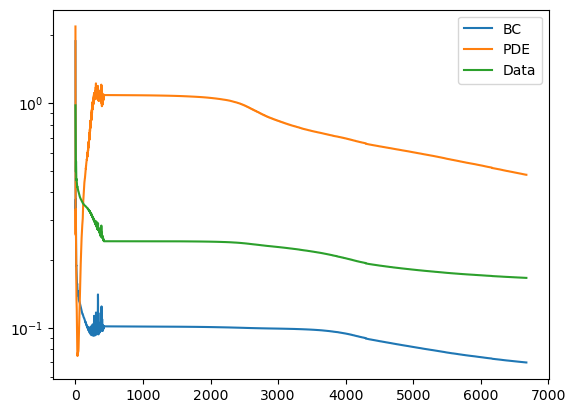

In [189]:
plt.plot(np.array(pinn2.loss_history["BC"])*1e5,label="BC")
plt.plot(np.array(pinn2.loss_history["PDE"])*1e6,label="PDE")
plt.plot(np.array(pinn2.loss_history["Data"]),label="Data")
plt.yscale("log")
plt.legend()

In [190]:
errors2=loss(pinn2(test_init_pos_main2),test_disp_main2)

(0.0, 0.2)

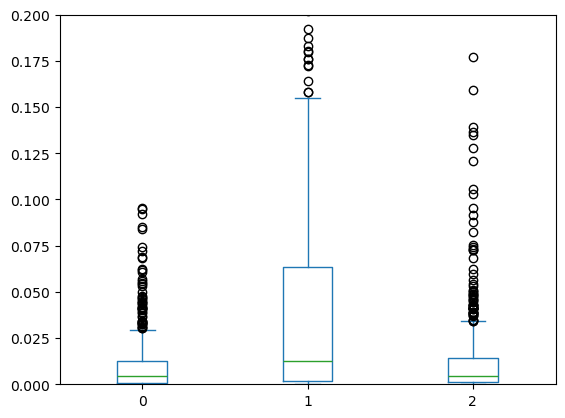

In [196]:
pd.DataFrame(errors2.cpu().detach().numpy()).plot(kind="box")
plt.ylim(0,0.2)

(0.0, 1.0)

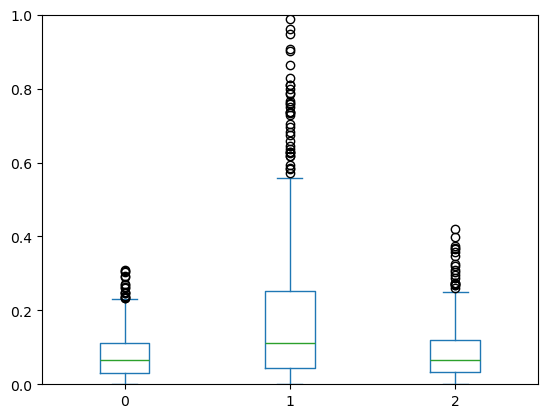

In [198]:
pd.DataFrame(torch.abs(pinn2(test_init_pos_main2)-test_disp_main2).cpu().detach().numpy()).plot(kind="box")
plt.ylim(0,1)

Incurrimos en el problema de siempre, que las medias de los errores de los desplazamientos están en el orden de los desplazamientos, que son milimetros-centimetros?  
Mientras que la los de la BC esta aplicada sobre los datos de tensiones que son Kpa? no se pero están en 1e-3.    
Y la PDE tiene más problemas aun, porque tenemos loss(sigma_real - C:epsilon). Epsilon está calculado con u, que tiene magnitudes comparables con las de entrada, entorno a 0.

1. No tenemos iguales aportaciones a la loss, de modo que algunas cantidades se buscan cumplir más que otras. Ahora tenemos que la data se busca mejorar frente al resto, y no se presta mucha atención a la BC que será la que nos permita predecir bien E, ni a PDE que es la que nos va a dar información extra para los puntos no vistos.  

Por el momento le pongo pesos a ojo para que las cantidades estén en el mismo orden de magnitud al hacer la backprop de la loss.  

Ideas extra sacadas de varios sitios:  
- 

In [45]:
pinn.C

AttributeError: 'PINN' object has no attribute 'C'

In [336]:
[i.item() for i in pinn.params_history["E"]][-10:]

[0.03071218729019165,
 0.030638694763183594,
 0.03056555986404419,
 0.030492544174194336,
 0.03041982650756836,
 0.030347228050231934,
 0.030274927616119385,
 0.030202746391296387,
 0.030130863189697266,
 0.03005903959274292]

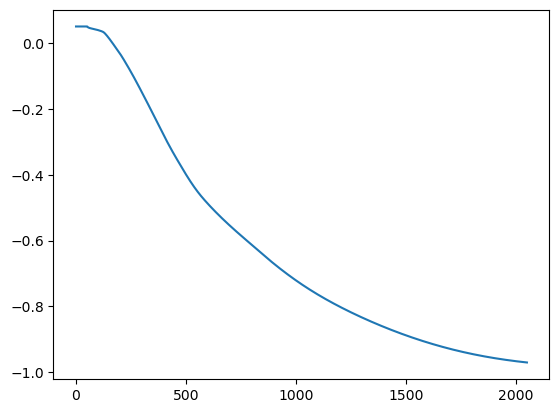

In [337]:
plt.plot([i.item() for i in pinn.params_history["alpha"]])

# DDEX y pruebas autograd

In [34]:

pinn=PINN([3,14,14,3],[2,3,4])


/tmp/ipykernel_10243/2404198933.py:30: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [35]:
# x1=torch.randn([30],requires_grad=True).to("cpu")
# x2=torch.randn([30],requires_grad=True).to("cpu")
# x3=torch.randn([30],requires_grad=True).to("cpu")
# X=torch.stack([x1,x2,x3],dim=1)
X=torch.randn([30,3],requires_grad=True).to("cuda")
x1=X[:,0].reshape(-1,1)
X.shape

torch.Size([30, 3])

In [36]:
y=pinn(X)
y

tensor([[ 0.2036,  0.2741, -0.3456],
        [ 0.0925,  0.3825,  0.2322],
        [-0.0454,  0.2009, -0.2854],
        [-0.3035, -0.3187, -0.2435],
        [-0.2676,  0.1590, -0.5100],
        [ 0.5444, -0.1023,  0.1319],
        [ 0.4544,  1.0185, -0.1494],
        [ 0.1568,  0.1912,  0.3833],
        [ 0.1458,  1.0734, -0.1743],
        [-0.3302, -1.2895,  0.2671],
        [-0.3320, -0.2111,  0.3653],
        [ 0.2395,  0.0842,  0.1687],
        [-0.0362, -0.8423,  0.5546],
        [ 0.0472, -0.3113, -0.2631],
        [-0.0980,  0.6193, -0.5986],
        [-0.4486, -0.3953,  0.2426],
        [ 0.0817,  0.7773, -0.5281],
        [-0.4070,  0.3180,  0.4533],
        [ 0.1936, -0.0874,  0.3108],
        [ 0.3120,  0.4554,  0.2953],
        [-0.4101,  0.6527, -0.1614],
        [-0.1685, -0.7659,  0.3039],
        [-0.4709, -0.7158, -0.2183],
        [-0.1363, -1.1246,  0.2580],
        [ 0.0629,  0.0626, -0.3761],
        [ 0.4773, -0.3780, -0.0095],
        [-0.3237,  0.3202, -0.4975],
 

In [37]:
x,y,z=pinn.compute_XYZ(X)

In [38]:
u,v,w=pinn.compute_displacements(x,y,z)

In [39]:
epsilon=pinn.compute_strain(x,y,z,u, v, w)

In [40]:
#strain_flat=strain[:,(0,1,2,1,0,0),(0,1,2,2,2,1)]*torch.tensor([1,1,1,2,2,2],dtype=torch.float32).to(device)
strain_flat=epsilon[:,(0,1,2,0,0,1),(0,1,2,1,2,2)]
strain_flat.shape

torch.Size([30, 6])

In [41]:
nu=2.0
E=1.0
C=(E/((1+nu)*(1-2*nu)))*torch.tensor(
        [[1-nu,nu,nu,0,0,0],
        [nu,1-nu,nu,0,0,0],
        [nu,nu,1-nu,0,0,0],
        [0,0,0,(1-2*nu)/2,0,0],
        [0,0,0,0,(1-2*nu)/2,0],
        [0,0,0,0,0,(1-2*nu)/2]]).float().to("cuda")
a=torch.matmul(C,strain_flat.T.float()).T.squeeze()

In [42]:
sigma=pinn.compute_stress(epsilon)
sigma.shape

torch.Size([30, 6])

In [43]:
pinn.divergence(sigma,x,y,z)

tensor([[ 0.2164, -0.7212,  0.5777],
        [-0.1004, -0.3578, -0.3169],
        [ 0.1412, -0.4319,  0.6826],
        [ 0.2173,  0.6775,  0.2942],
        [ 0.6122, -0.3196,  0.7825],
        [-0.7018,  0.3510,  0.0092],
        [-0.3423, -0.5681,  0.4467],
        [-0.6779,  0.5815, -0.6340],
        [ 0.1369, -1.5308,  0.7013],
        [ 0.4460,  0.4016, -0.1963],
        [-0.3432,  0.4088, -0.6983],
        [-0.2649, -0.2344, -0.2761],
        [-0.0352,  0.2835, -0.4109],
        [ 0.2494, -0.0865,  0.5268],
        [ 0.2281, -0.2082,  0.5426],
        [ 0.1375,  0.1141, -0.6114],
        [-0.0173, -0.3727,  0.3007],
        [-0.5411,  0.0882, -0.7284],
        [-0.3171,  0.1401, -0.6773],
        [-0.3241, -0.6587, -0.3398],
        [ 0.9779, -0.9985,  0.2715],
        [ 0.2255,  0.8108, -0.5545],
        [-0.1071,  1.2819, -0.0567],
        [ 0.0934,  1.1609, -0.6818],
        [ 0.4827, -0.8142,  0.6434],
        [-1.0092,  0.7332,  0.1085],
        [ 0.3417, -0.1929,  0.7881],
 

In [44]:
autograd.grad(sigma[:,0],(x,y),grad_outputs=torch.ones_like(sigma[:,0]),retain_graph=True)[1]


tensor([[ 0.6544],
        [-0.0213],
        [ 0.6410],
        [ 0.0293],
        [ 0.5704],
        [-0.3237],
        [ 0.7192],
        [-0.5146],
        [ 0.9117],
        [-0.3908],
        [-0.5862],
        [-0.1723],
        [-0.2496],
        [ 0.2317],
        [ 0.2310],
        [-0.6450],
        [ 0.2259],
        [-0.4093],
        [-0.5512],
        [-0.0313],
        [ 0.7927],
        [-0.7740],
        [-0.4406],
        [-0.7399],
        [ 0.6091],
        [-0.4515],
        [ 0.5983],
        [-0.3121],
        [ 0.1155],
        [ 0.7333]])

In [75]:
dde.gradients.jacobian(y,X,i=0,j=2)

tensor([[-0.1307],
        [-0.3491],
        [-0.3558],
        [-0.3587],
        [-0.3415],
        [-0.3003],
        [-0.3599],
        [-0.2743],
        [-0.3231],
        [-0.3407],
        [-0.2494],
        [-0.2730],
        [-0.2762],
        [-0.2505],
        [-0.3960],
        [-0.0742],
        [-0.2699],
        [-0.1811],
        [-0.2346],
        [-0.3323],
        [-0.2476],
        [-0.2374],
        [-0.1814],
        [-0.3360],
        [-0.2278],
        [-0.2573],
        [-0.3492],
        [-0.1643],
        [-0.3686],
        [-0.3068]], grad_fn=<SliceBackward0>)

In [60]:
u=y[:,0].reshape(-1,1)
v=y[:,1].reshape(-1,1)
w=y[:,2].reshape(-1,1)


In [229]:
autograd.grad(y,x1,grad_outputs=torch.ones(y.shape[0],3).to("cuda"),allow_unused=True,retain_graph=True)


(tensor([-0.0659,  0.2257, -0.1269, -0.1927,  0.2281,  0.0342,  0.1136,  0.0081,
          0.0216,  0.2476,  0.0974, -0.0360,  0.0762,  0.1903,  0.0621,  0.0816,
          0.0100, -0.0140,  0.2266,  0.0691, -0.0033,  0.1553,  0.1227, -0.1195,
          0.1057,  0.1504, -0.0533,  0.0926, -0.0106,  0.0489], device='cuda:0'),)

In [233]:
torch.sum(torch.stack([autograd.grad(u,x1,grad_outputs=torch.ones(u.shape[0],1).to("cuda"),allow_unused=True,retain_graph=True)[0],
                       autograd.grad(v,x1,grad_outputs=torch.ones(v.shape[0],1).to("cuda"),allow_unused=True,retain_graph=True)[0],
                       autograd.grad(w,x1,grad_outputs=torch.ones(w.shape[0],1).to("cuda"),allow_unused=True,retain_graph=True)[0]]),axis=0)

tensor([-0.0659,  0.2257, -0.1269, -0.1927,  0.2281,  0.0342,  0.1136,  0.0081,
         0.0216,  0.2476,  0.0974, -0.0360,  0.0762,  0.1903,  0.0621,  0.0816,
         0.0100, -0.0140,  0.2266,  0.0691, -0.0033,  0.1553,  0.1227, -0.1195,
         0.1057,  0.1504, -0.0533,  0.0926, -0.0106,  0.0489], device='cuda:0')

In [166]:
autograd.grad(c,b_aux,grad_outputs=torch.ones(3,1,3),allow_unused=True)

(None,)

In [108]:
c=torch.stack([a*2*b,b*2,a*b]).reshape(1,3,-1)
b=b.reshape(1,-1)


In [113]:
divergence(b,c)

RuntimeError: Mismatch in shape: grad_output[0] has a shape of torch.Size([1, 1]) and output[0] has a shape of torch.Size([3]).